# $\chi^2$ Investigations

In this notebook we first investigate how the `absolute_simga` parameter of `curve_fit` can affect the inferred uncertainty on the data.

To this end, we simulate many dataset using a normal distribution:

$$ y\sim \mathcal{N}(\mu, \sigma_y)$$

With $\mu$ the true position as given by our model and $\sigma_y$ the uncertainty (standard error) of the data $y$.

First we define our model:

In [33]:
import numpy as np
# basic imports
import scipy.stats
from scipy.optimize import curve_fit
from pylab import * #lazy

# let's define our model
np.random.seed(10) # fix seed to compare results

# we fix the true values of the parameters
a_true = 2
b_true = 3

# we fix the range of the independent variable (say, time)
xmin = 0.1
xmax = 10

def linear_model(x, a, b):
	'''
	a line
	'''
	return a + x*b

This function simulates data. We may assume that the uncertainty on $y$ is a fixed fraction of the true value.

In [34]:
def sim_data(x, fractional_uncertainty=0.2):

	# find the model prediction
	y_true = model(x, a_true, b_true)

	# find the true uncertainty on the observations
	y_unc_true = np.abs(y_true)*fractional_uncertainty

	# generate data for a normal distribution
	y_sample = np.random.normal(y_true, y_unc_true, size=len(x))

	return y_sample, y_unc_true


_the cell below allows you to toggle between models (these will be added later)_

In [35]:
# lets pick one model
model = linear_model
#model = non_linear_model # you might add this later



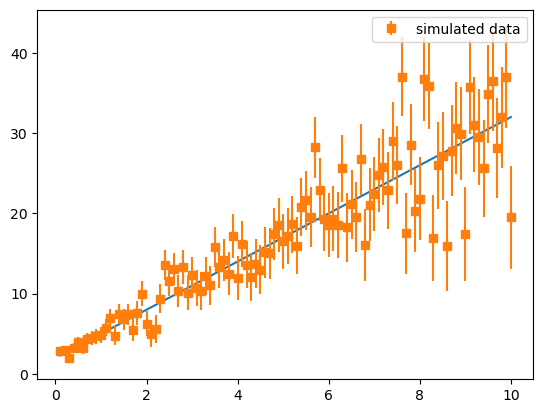

if you think this looks weird, it helps to look in log-space


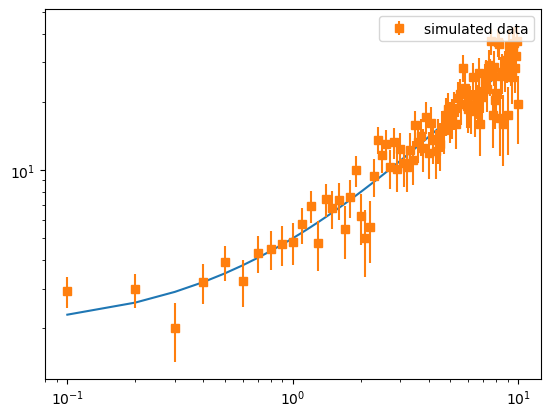

In [36]:
	# plot the simulation results
xx = np.linspace(xmin, xmax, 100)
data_example = sim_data(xx)

plt.clf()
plt.plot(xx, model(xx, a_true, b_true))
plt.errorbar(xx, data_example[0],data_example[1], fmt='s', label='simulated data')
plt.legend()
plt.pause(0.1)
print('if you think this looks weird, it helps to look in log-space')

plt.clf()
plt.plot(xx, model(xx, a_true, b_true))
plt.errorbar(xx, data_example[0],data_example[1], fmt='s', label='simulated data')
plt.legend()
plt.yscale('log')
plt.xscale('log')

## Part 1: $\chi^2$ rescaling of `curve_fit`

Make 5000 simulation of a dataset with N=3 points. Of each simulation, find the standard error on the slope ($\sigma_{b}$) of the best-fit line using `curve_fit` with `absolute_sigma=False` (the default). In this setting the uncertainties are rescaled using the $\chi^2$ of the best-fit parameters.

- Plot a distribution of the 5000 $\chi^2$ and compare to the theoretical value (see `scipy.stats.chi2`).

- Compare the distribution of $\sigma_{b}$ with the "correct" value. How often is confidence interval with $\chi^2$-rescaling a factor 2 larger compared to the correct value?

- Repeat the last step with $N=10$ datapoints.

In [37]:
N_points = 10
x = np.linspace(0.1, 10, N_points)
N_sims = 5000
sigma_bs = np.zeros(N_sims)
chi_2 = np.zeros(N_sims)
true_value = 0

for i in range(N_sims):
	y_sam, y_unc = sim_data(x)
	popt, pcov = curve_fit(model, x, y_sam, sigma=y_unc, absolute_sigma=False)
	_, true_value_pcov = curve_fit(model, x, y_sam, sigma=y_unc, absolute_sigma=True)
	true_value = np.sqrt(true_value_pcov[1, 1])
	y_fit = model(x, *popt)
	chi_2[i] = np.sum(np.square(y_sam-y_fit)/y_unc**2)
	sigma_bs[i] = np.sqrt(pcov[1, 1])

chi_theoretical = scipy.stats.chi2(len(x)-2)

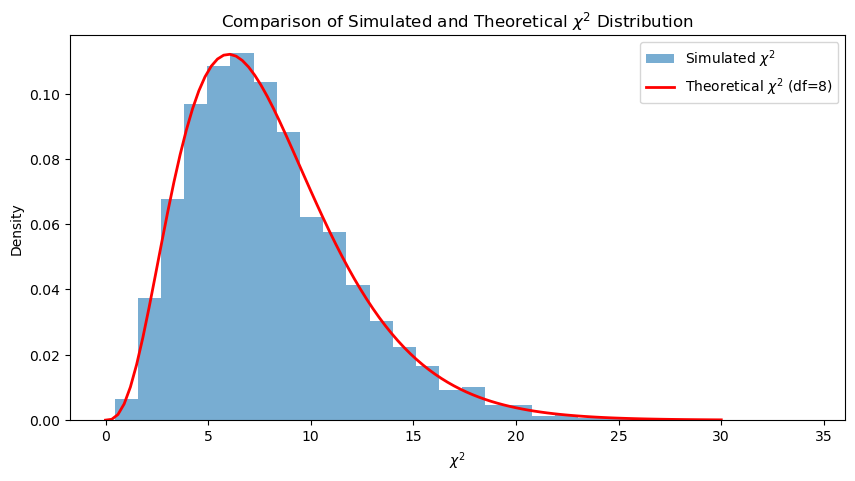

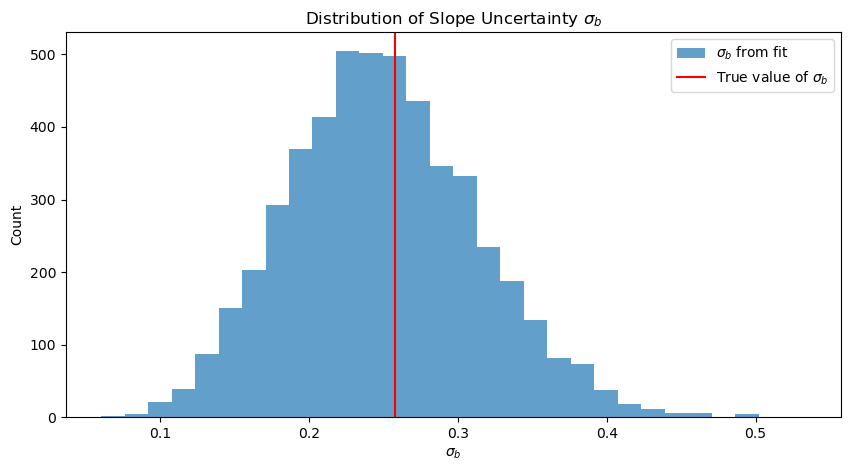

In [38]:
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Plot histogram of chi^2 values
plt.figure(figsize=(10, 5))

# Chi^2 distribution for the simulation results
plt.hist(chi_2, bins=30, density=True, alpha=0.6, label='Simulated $\chi^2$')

# Theoretical chi^2 distribution (for df=1)
x_vals = np.linspace(0, 30, 100)
plt.plot(x_vals, chi2.pdf(x_vals, df=N_points-2), 'r-', lw=2, label=f'Theoretical $\chi^2$ (df={N_points-2})')

plt.title('Comparison of Simulated and Theoretical $\chi^2$ Distribution')
plt.xlabel('$\chi^2$')
plt.ylabel('Density')
plt.legend()
plt.show()

# Plot distribution of sigma_b values
plt.figure(figsize=(10, 5))
plt.hist(sigma_bs, bins=30, alpha=0.7, label=r'$\sigma_b$ from fit')
plt.axvline(x=true_value, label=r'True value of $\sigma_b$', color='r')

plt.title('Distribution of Slope Uncertainty $\sigma_b$')
plt.xlabel(r'$\sigma_b$')
plt.ylabel('Count')
plt.legend()
plt.show()


In [39]:
np.mean(chi_2), np.std(chi_2)

(8.013470805411266, 4.020353453063317)

## Part 2: Bootstrap and non-linear least-squares

First let's check that bootstrap works for our linear model. Let's do a non-parametric bootstap:

-  simulate _a single_ dataset with $N=400$ points
- Draw $B=20000$ bootstrap samples.
- Compare the bootstrapped distribution of the parameter $b$ with the normal distribution, $\mathcal{N}(0,\sigma_b)$, predicted by the least-squares fit.

You should find good agreement.

In [75]:
N = 400
B = 20000
x = np.linspace(0.1, 10, N)
y_sam, y_unc = sim_data(x, fractional_uncertainty=0.2)
sigma_bs = np.zeros(B)
bs = np.zeros(B)

true_popt, true_value_pcov = curve_fit(model, x, y_sam, sigma=y_unc, absolute_sigma=True)
true_value = np.sqrt(true_value_pcov[1, 1])

for i in range(B):
	indices = np.random.randint(0, N, size=N)
	bootstrap = y_sam[indices]
	bootstrap_unc = y_unc[indices]
	popt, pcov = curve_fit(model, x[indices], bootstrap, sigma=bootstrap_unc, absolute_sigma=False)
	
	sigma_bs[i] = np.sqrt(pcov[1, 1])
	bs[i] = popt[1]	

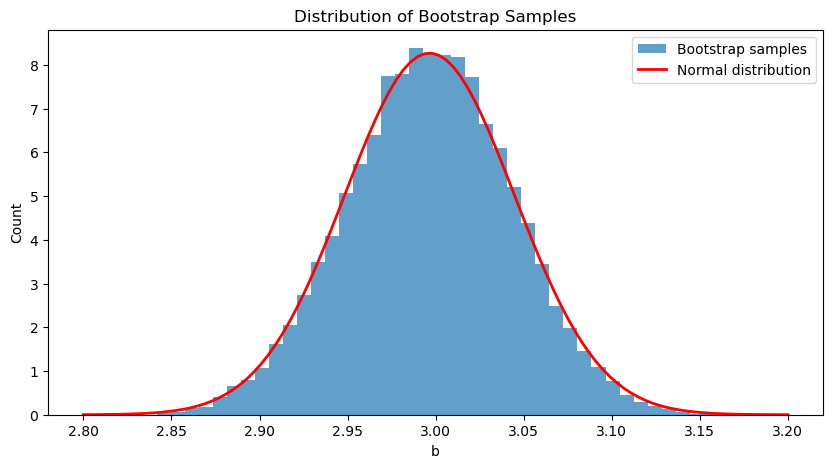

In [80]:
import matplotlib.pyplot as plt

# Plot distribution of bootstrap values
plt.figure(figsize=(10, 5))
plt.hist(bs, bins=50, alpha=0.7, label='Bootstrap samples', density=True)

x_vals = np.linspace(2.8, 3.2, 100)
plt.plot(x_vals, scipy.stats.norm.pdf(x_vals, loc=true_popt[1], scale=np.mean(sigma_bs)), 'r-', lw=2, label='Normal distribution')
plt.title('Distribution of Bootstrap Samples')
plt.xlabel('b')
plt.ylabel('Count')
plt.legend()
plt.show()

The documentation of `curve_fit` says:  
>Note that the relationship between cov and parameter error estimates is derived based on a linear approximation to the model function around the optimum [1]. When this approximation becomes inaccurate, cov may not provide an accurate measure of uncertainty.

But how bad can it be? Let's check. Again we use only two parameters $a$ and $b$.  

We know that the bootstrap will give a more correct answer than least-squares, so we can use this to check the preformance of `curve_fit` confidence intervals.

- dream-up a non-linear model that combines $a$ and $b$, add this above and set `model = non_linear_model`
- Redo comparison of the bootstrap confidence interval with least-squares normal distribution.
 - do you see any difference?
 - Does least-squares aways under/over predict the uncertainty?

In [77]:
true_popt

array([2.07646473, 2.99653764])

In [46]:
len(set(indices))

255

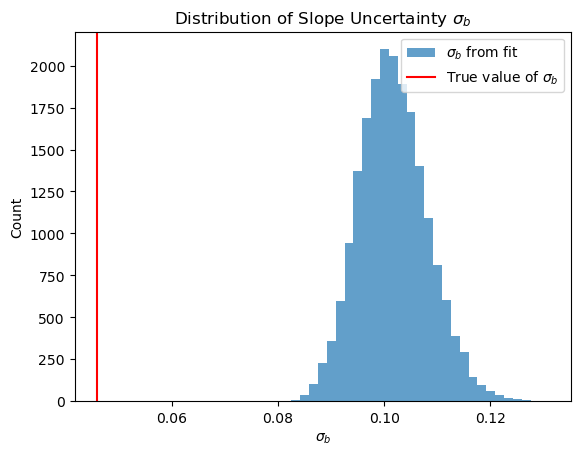

In [48]:
plt.hist(sigma_bs, bins=30, alpha=0.7, label=r'$\sigma_b$ from fit')
plt.axvline(x=true_value, label=r'True value of $\sigma_b$', color='r')

plt.title('Distribution of Slope Uncertainty $\sigma_b$')
plt.xlabel(r'$\sigma_b$')
plt.ylabel('Count')
plt.legend()
plt.show()